In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random as rand
plt.style.use('seaborn')

# Branch-and-Bound algorithm for 2-dimensional plane

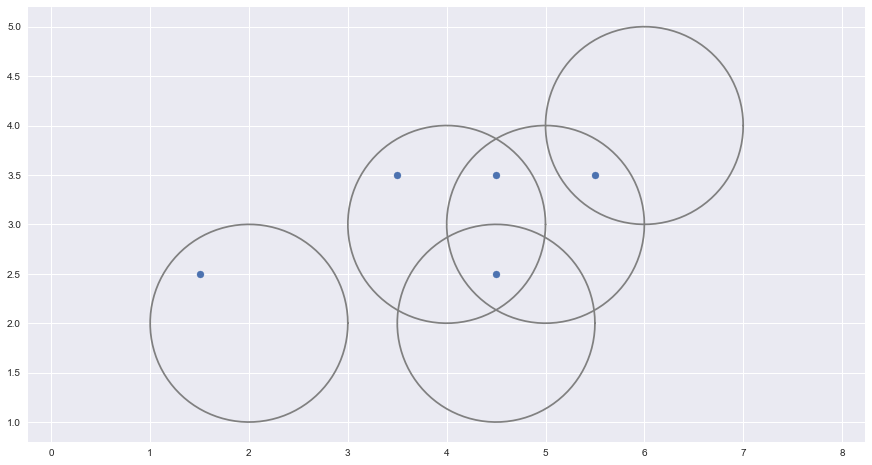

In [168]:
class Disk:
    
    def __init__(self, x, y):
        self.center = (x, y)
        
    def contains(self, point):
        # True if the distance between the center and the given point <= 1
        return ((self.center[0] - point[0]) ** 2 + (self.center[1] - point[1]) ** 2) ** 0.5 <= 1
    
    def __repr__(self):
        return f"({self.center[0]}, {self.center[1]})"
    
    
# Visualizing points and disks
def show(P, Q, figsize=(15, 8), colors=None):
    plt.figure(figsize=figsize)
    plt.axis('equal')
    
    # Plot points
    points = np.array(P).reshape((len(P), 2))
    plt.scatter(points[:,0], points[:,1])
    
    # Plot disks
    i = 0
    for disk in Q:
        theta = np.linspace(0, 2*np.pi, 100)
        r = np.sqrt(1.0)
        x1 = r*np.cos(theta) + disk.center[0]
        x2 = r*np.sin(theta) + disk.center[1]
        plt.plot(x1, x2, color='grey' if colors is None else colors[i])
        i+=1
        
P = [(1.5, 2.5), (3.5, 3.5), (4.5, 2.5), (4.5, 3.5), (5.5, 3.5)]
Q = [Disk(2, 2), Disk(4, 3), Disk(4.5, 2), Disk(5, 3), Disk(6, 4)]
show(P, Q)

## NP-hardness proof

In order to prove the NP-hardness of DUDC, we can reduce it to the Minimum Steiner Tree problem (MST).

Let $P$ a set of points and $Q$ a set of disks in the DUDC problem. Let $k$ be an integer. The DUDC problem can be formulate as follow : is there a subset $Q^* \subseteq Q$ such that $|Q^*| \leq k$ ?

### Graph construction

Let $G=(V, E)$ be the final graph. We call $T$ the terminal nodes and $S$ the Steiner nodes.

The idea of the construction is the following :
* for each disk $d \in Q$, create a Steiner node $s_{d}$ and add it to $S$, the set of Steiner nodes.
* for each points $p \in P$, create a terminal node $t_{p}$ and add it to $T$, the set of terminal nodes.
* Create a node $u \in T$ and add an edge between $u$ and $t_{p}, \forall t_{p} \in T-\{u\}$ 
* If a point $p \in P$ belongs to a disk $d \in Q$, then add an edge between $t_{p}$ and $s_{d}$, their corresponding node in the graph G.

<img src="https://github.com/vesran/aap/Yves/resources/dudc_nphard.png" width="00"> <img src="https://github.com/vesran/aap/Yves/resources/mst_nphard.png" width="400">

### Reduction proof

Let's show that **there is a solution for DUDC of size $k$ $\iff$ there is a solution of size $k+|T|$ for MST.** (size = number of edges)

(Sufficiency) Suppose there is a minimum Steiner tree $R^*$ in $G$. All Steiner nodes must be covered. One can show that the covered nodes in $S$ in MST corresponds to a set of disks $Q^{*}$ in DUDC. Indeed, let a point $p \in P$ from DUDC and its corresponding node $t_{p} \in T$ in MST. The parent of $t_{p}$ in $R^*$ are some Steiner nodes $\{s_1, s_2 ..., s_l\}$. Since $t_{p}$ is linked to $s_i$ iff the corresponding disk of $s_i$ contains $p$, taking the corresponding disk of $s_i$ in $Q^*$ will lead us to a solution of size $k$ for DUDC (since there are only $k$ edges from $u$ to $S$ which are in $R^*$).

(Necessity) Suppose we have a solution $Q^*$ for DUDC. We can build a Steiner tree $R$ by taking the edges from $u$ to the Steiner nodes that correspond to a disk in $Q^*$ and the edges from these Steiner nodes to all ternimal nodes (if a terminal node is adjacent to 2 or more of these Steiner nodes, we take only one of its incident edges). All terminal nodes must be covered since all points of $P$ are covered in DUDC. Moreover, $R$ does not contain any cycle, therefore $R$ is a Steiner tree of size $k+|T|$.

In conclusion, there is a solution for DUDC of size $k$ $\iff$ there is a solution of size $k+|T|$ for MST. Therefore, DUDC is NP-hard.

## Implementation of Branch-and-bound algorithm

[(6, 4), (2, 2), (4.5, 2), (4, 3), (5, 3), (0, 0)]
Interation 0 [(0, 0)]
Current node is  (0, 0) disk (6, 4)
Best solution is None
Interation 1 [(1, 2), (0, 0)]
Current node is  (0, 0) disk (2, 2)
Best solution is None
Interation 2 [(1, 2), (1, 3)]
Current node is  (1, 2) disk (2, 2)
Best solution is None
Interation 3 [(1, 3), (2, 5)]
Current node is  (1, 3) disk (4.5, 2)
Best solution is None
Interation 4 [(2, 5), (2, 4), (1, 3)]
Current node is  (1, 3) disk (4, 3)
Best solution is None
Interation 5 [(2, 5), (2, 4), (2, 6)]
Current node is  (2, 4) disk (4, 3)
Best solution is None
Interation 6 [(2, 5), (2, 6), (3, 6)]
Current node is  (2, 5) disk (4.5, 2)
Best solution is None
Interation 7 [(2, 6), (3, 6), (3, 6), (2, 5)]
Current node is  (2, 5) disk (4, 3)
Best solution is (3, 8)
Interation 8 [(2, 6), (3, 6), (3, 6)]
Current node is  (2, 6) disk (5, 3)
Best solution is (3, 8)
Interation 9 [(3, 6), (3, 6)]
Current node is  (3, 6) disk (5, 3)
Best solution is (3, 8)
Interation 10 [(3, 

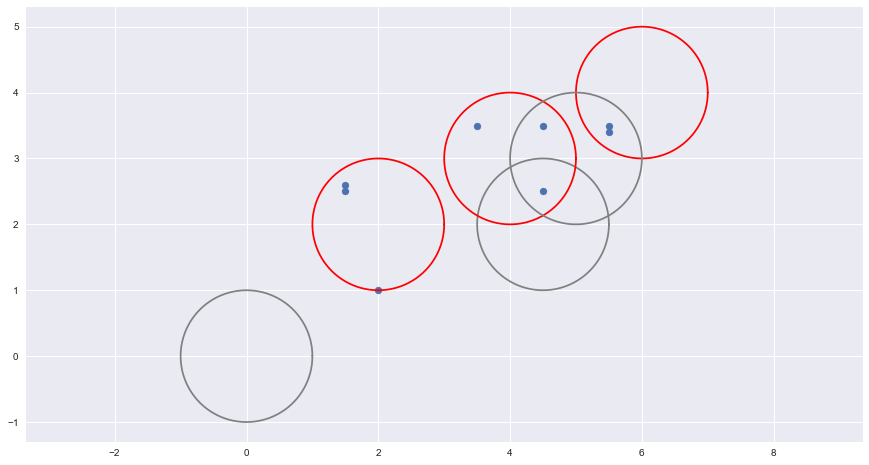

In [164]:
class BBTree:
    
    def __init__(self, P, Q, solution=None, nb_covered_points=0):
        self.solution = solution
        self.nb_covered_points = nb_covered_points
        self.P = P
        self.Q = Q
        self.h_value = self.heuristic()
        self.children = []
        
    def add_child(self, child):
        self.children.append(child)
    
    def heuristic(self):
        return self.nb_covered_points  # Number of covered points
    
    def is_realizable(self, best_score):
        # Check if there is a point that does not belong to any disk
        for point in self.P:
            outlier = True
            for disk in self.Q:
                if disk.contains(point):
                    outlier = False
                    break
            if outlier:
                return False
        # Cannot be realizable if no disk is left nor the current solution size is too high
        return len(self.Q) > 0 and best_score > len(self.solution)
    
    def __repr__(self):
        return f'({len(self.solution)}, {self.h_value})'
    
    def split(self):
        # Check leaf condition
        if len(self.Q) == 0 or len(self.P) == 0:
            print("Leaf cannot be split")
            return None
        
        current_disk = self.Q[0]
        remain_pts = [point for point in self.P if not current_disk.contains(point)]
        nb_cov_pts = self.nb_covered_points + len(self.P) - len(remain_pts)
        left_sol = self.solution + [current_disk]
            
        # Disk is added to left node, not to right node
        left = BBTree(remain_pts, self.Q[1:], solution=left_sol, nb_covered_points=nb_cov_pts) 
        right = BBTree(self.P, self.Q[1:], solution=self.solution, nb_covered_points=self.nb_covered_points)  
        return left, right
            
            
            
def dudc_branch_and_bound(P, Q):
    '''Returns the optimal solution and the tree'''
    root = BBTree(P, Q, solution=[])
    to_visit = [root]
    best_solution_size, best_solution = len(Q)+1, None  # Best solution's size is upper bounded
    tree_to_develop = None
    
    i = 0
    while len(to_visit) != 0:
        print("Interation", i, to_visit)
        i += 1
        
        # Select the best realizable node
        tree_to_develop = to_visit[0]
        for tree in to_visit:
            if tree.h_value < tree_to_develop.h_value:
                tree_to_develop = tree
        print("Current node is", tree_to_develop, "disk", tree_to_develop.Q[0])
        to_visit.remove(tree_to_develop)
        
        # Find children
        children = tree_to_develop.split()
        if children is not None:   
            for child in children:
                # Add not realizable node to tree for future visualisation
                tree_to_develop.add_child(child)
                
                child_is_solution = all(any(disk.contains(pt) for disk in child.solution) for pt in P)
                if child.is_realizable(best_solution_size) and not child_is_solution:
                    to_visit.append(child)
                elif child_is_solution and len(child.solution) < best_solution_size:
                    best_solution_size = len(child.solution)
                    best_solution = child
        print(f"Best solution is {best_solution}")
    return best_solution, root


P = [(1.5, 2.5), (3.5, 3.5), (4.5, 2.5), (4.5, 3.5), (5.5, 3.5), (5.5, 3.4), (1.5, 2.6), (2, 1)]
Q = [Disk(0, 0), Disk(2, 2), Disk(4, 3), Disk(4.5, 2), Disk(5, 3), Disk(6, 4)]
rand.shuffle(Q)
print(Q)
sol_node, root = dudc_branch_and_bound(P, Q)

if sol_node is not None:
    colors = ['red' if disk in sol_node.solution else 'grey' for disk in Q]
    show(P, Q, colors=colors)


                        /-(4, 8)
                  /(3, 6)
                 |      \-(3, 6)
            /(2, 5)
           |     |      /-(3, 8)
      /(1, 2)     \(2, 5)
     |     |            \-(2, 5)
     |     |
     |      \-(1, 2)
     |
     |                        /-(4, 8)
-(0, 0)                 /(3, 6)
     |            /(2, 4)     \-(3, 6)
     |           |     |
     |           |      \-(2, 4)
     |      /(1, 3)
     |     |     |            /-(3, 8)
     |     |     |      /(2, 6)
      \(0, 0)     \(1, 3)     \-(2, 6)
           |           |
           |            \-(1, 3)
           |
            \-(0, 0)


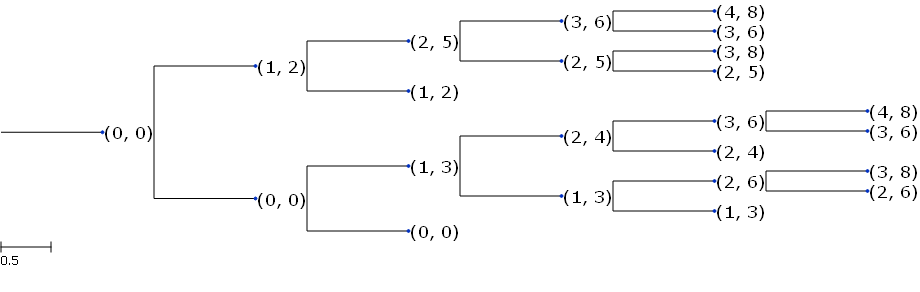

In [166]:
import ete3 # pip install ete3 PyQt5

def BBTree2ete(bbtree):
    '''Converts a branch-and-bound tree to an ete3 tree for visualisation'''
    res_tree = ete3.Tree()
    res_tree.name = repr(bbtree)
    bbtree_to_visit = [bbtree]
    ete_to_visit = [res_tree]
    
    while len(bbtree_to_visit) > 0:
        current_bbtree = bbtree_to_visit.pop(0)
        current_ete = ete_to_visit.pop(0)
        
        for bbchild in current_bbtree.children:
            ete_child = ete3.Tree(name=repr(bbchild))
            current_ete.add_child(ete_child)
            
            # Visit child's children if it's not a leaf
            if len(bbchild.children) > 0:
                bbtree_to_visit.append(bbchild)
                ete_to_visit.append(ete_child)
                
    return res_tree
    
def my_layout(node):
    # Adds the name face to the image at the preferred position
    name_face = AttrFace("name")
    faces.add_face_to_node(name_face, node, column=0, position="branch-right")
    
# Tree style parameters
ts = ete3.TreeStyle()
ts.scale =  100 # 100 pixels per branch length unit
ete_tree = BBTree2ete(root)
ts.show_leaf_name = False
ts.layout_fn = my_layout   

# Display
print(ete_tree.get_ascii(show_internal=True))
ete_tree.render("%%inline", tree_style=ts)